In [4]:
# This cells gives formatting to the images embedded in this Notebook
from IPython.core.display import HTML
HTML("""
<style>
img[alt=image] { width: 300px; }
</style>
""");

<h1><center>Pulsar Classification</center></h1>
![image](https://cdn.spacetelescope.org/archives/images/screen/opo0224a.jpg)

<p style="font-family: Arial; font-size:1.1em;color:black"><br>

Pulsars are a rare type of Neutron star that produce radio emissions detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.<br><br>

In this notebook we will use the HTRU2 data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South) to attempt to create a classifier model that can predict with 90 percent or greater accuracy  whether an observation is a pulsar or not.<br><br>

This data was taken from the UCI Machine Learning Repository. A link to the data is given below.<br>
https://archive.ics.uci.edu/ml/datasets/HTRU2# <br><br>

The data set contains 16,259 spurious examples caused by RFI/noise, and 1,639
real pulsar examples. These examples have all been checked by human annotators. Each
candidate is described by 8 continuous variables.<br><br>

1. Mean of the integrated profile.<br>
2. Standard deviation of the integrated profile.<br>
3. Excess kurtosis of the integrated profile.<br>
4. Skewness of the integrated profile.<br>
5. Mean of the DM-SNR curve.<br>
6. Standard deviation of the DM-SNR curve.<br>
7. Excess kurtosis of the DM-SNR curve.<br>
8. Skewness of the DM-SNR curve.<br><br>

A ninth column in the data set indicates whether an observation is an actual pulsar (value of 1) or a spurious example
(value of 0).

<br><br></p>

In [210]:
# import appropriate libraries
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from operator import itemgetter
from sklearn.feature_selection import RFE

Read the file containing the data.  File is located in the current working directory.

In [213]:
HTRU2_data = pd.read_csv('HTRU_2.csv')

Check to see if there are any missing (null) data in the file we imported:

In [215]:
HTRU2_data.isnull().any(axis=1).any()

False

Set the column names for the dataframe

In [216]:
features = ["mean.integrated.profile","std.integrated.profile","excess.kurtosis.integrated.profile",
               "skewness.integrated.profile","mean.DM-SNR.curve","std.DM-SNR.curve",
               "excess.kurtosis.DM-SNR.curve","skewness.DM-SNR.curve"]

In [217]:
target = ["class"]

Add the column names to the data frame

In [219]:
HTRU2_data.columns = features + target

Lets take a look at the data:

In [220]:
HTRU2_data.head()

,mean.integrated.profile,std.integrated.profile,excess.kurtosis.integrated.profile,skewness.integrated.profile,mean.DM-SNR.curve,std.DM-SNR.curve,excess.kurtosis.DM-SNR.curve,skewness.DM-SNR.curve,class
0,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
1,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
2,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
3,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
4,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0


Are there any observations with missing/NA values?

In [221]:
HTRU2_data.isnull().any(axis=1).any()

False

Create a data frame of the features to be used in training the classification model

In [222]:
pulsar_Data = HTRU2_data.copy()

In [223]:
X = pulsar_Data[features].copy()

Create the data frame that holds the target values for the observations.

In [224]:
y = pulsar_Data['class'].copy()

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Data / algorithm analysis and pre-processing.
<br><br></p>

We're going to use a Decision Tree Classifier to create a model.  Lets try and find the best set of parameters to use in our decision tree classifier.  The code below was adapted from https://blog.taiker.space/ml-implement-decision-tree-in-python-with-cross-validation/

In [225]:
parameters = {"criterion": ["gini", "entropy"],
              "min_samples_split": randint(2, 20),
              "max_depth": randint(5, 10),
              "min_samples_leaf": randint(1, 20),
              "max_leaf_nodes": randint(10, 20)}

clf = DecisionTreeClassifier()

In [226]:
# Use the RandomizedSearchCV method to perform a randomized search on hyper parameters.
best_param_search = RandomizedSearchCV(clf,param_distributions=parameters,n_iter=20)

In [227]:
# call the fit method to figure out the best parameters to use in the DecisionTreeClassifier
bestParamSearchFit = best_param_search.fit(X,y) 

Look at the top three parameter settings:

In [228]:
top_parameters = report_top_parameters(bestParamSearchFit.grid_scores_,3)

Model with rank: 1
Mean validation score: 0.980 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_leaf_nodes': 12, 'min_samples_leaf': 19, 'min_samples_split': 11}

Model with rank: 2
Mean validation score: 0.980 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 11, 'min_samples_leaf': 17, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.979 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_leaf': 16, 'min_samples_split': 11}



Now lets look at the features by looking at the results from using the <b>Recursive Feature Eliminiation<b> method.

In [233]:
# create the RFE model
rfe = RFE(clf)
rfe = rfe.fit(X,y)

In [234]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False  True  True False]
[1 2 1 4 3 1 1 5]


Use the results of the RFE model to select a subset of the pulsar data that is most important.

In [251]:
pulsarData = pulsar_Data.iloc[:,[0,2,5,6,8]].copy()
pulsarData.head()

,mean.integrated.profile,excess.kurtosis.integrated.profile,std.DM-SNR.curve,excess.kurtosis.DM-SNR.curve,class
0,102.507812,0.465318,14.860146,10.576487,0
1,103.015625,0.323328,21.744669,7.735822,0
2,136.750000,-0.068415,20.959280,6.896499,0
3,88.726562,0.600866,11.468720,14.269573,0
4,93.570312,0.531905,14.545074,10.621748,0


In [254]:
important_features = ["mean.integrated.profile","excess.kurtosis.integrated.profile",
               "std.DM-SNR.curve","excess.kurtosis.DM-SNR.curve"]

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Create our training and test data sets.
<br><br></p>

In [255]:
Xrfe = pulsarData[important_features]

In [256]:
yrfe = pulsarData['class']

In [268]:
X_train, X_test, y_train, y_test = train_test_split(Xrfe, yrfe, test_size=0.33, random_state=222)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Fit on Train Set
<br><br></p>

Using the output from above, lets create our classifier model based on the parameters of the model having Rank 1 above.

In [269]:
pulsar_classifier = DecisionTreeClassifier(criterion='entropy',max_depth=9,max_leaf_nodes=12,
                                           min_samples_leaf = 19,min_samples_split=10, random_state=1234)

In [270]:
pulsar_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=12,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

Lets plot the features and their importance to building the model

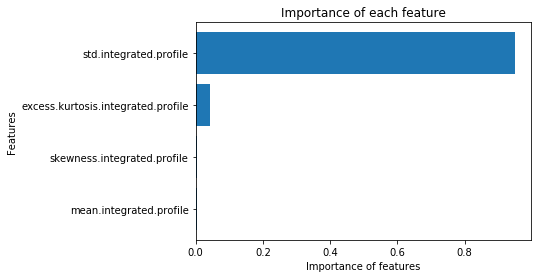

In [271]:
imp = pulsar_classifier.feature_importances_
names = pulsar_Data.columns

imp,names = zip(*sorted(zip(imp,names)))

plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)),names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

The above plot code is based on a code snipet from http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Predict on Test Set 

<br><br></p>

In [272]:
# Decision Tree Classifier
predictions = pulsar_classifier.predict(X_test)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Measure Accuracy of the Classifier
<br><br></p>

In [273]:
print('Decision Tree Accuracy score: {0:0.2f}'.format(accuracy_score(y_true = y_test, y_pred = predictions)*100) + "%")

Decision Tree Accuracy score: 98.04%


This accuracy score seems really good but does it really reflect how well the classifier performs?  Lets look at some other performace metrics. First we look at the cross validation metrics.  Because our data is unbalanced (16,259 spurious examples vs 1,639 actaul pulsars), we use the <i>scoring</i> parameter in the <b>cross_val_score</b> method with a value equal to 'f1'.

In [274]:
scores = cross_val_score(pulsar_classifier, Xrfe, yrfe, cv=10,scoring='f1')
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),scores.std()),end="\n\n")

mean: 0.868 (std: 0.017)



In [275]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.03)


We see that the accuracy reported by the <i>accuracy_score</i> method is quite a bit higher than the accuracy reported by cross validation. This is due to the unbalanced nature of the original data.

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Look at the Confusion Matrix
<br><br></p>
<p>The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier</p>

In [276]:
# Decision Tree Classifier
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=['Predicted Not Pulsar', 'Predicted Pulsar'],
    index=['Not Pulsar', 'Pulsar']
)

,Predicted Not Pulsar,Predicted Pulsar
Not Pulsar,5341,19
Pulsar,97,450


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Receiver Operating Characteristic (ROC)
<br><br></p>
ROC curves are typically used in binary classification to study the output of a classifier.<br><br>
See https://en.wikipedia.org/wiki/Receiver_operating_characteristic and 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html <br>for more details<br><br>

In [277]:
from sklearn import metrics
# Compute ROC curve and ROC area
fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

In [278]:
%matplotlib inline
import matplotlib.pyplot as plt

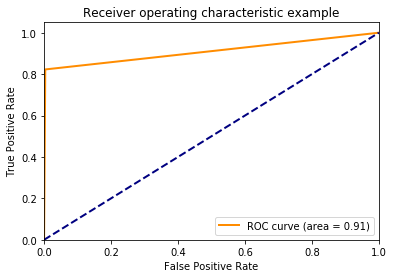

In [279]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.  The accuracy is measured by the area under the ROC curve (.91) and we see good accuracy from the model.

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>
Precision - Recall
<br><br></p>
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. Recall that the
data set being used has 1639 positive examples and 16259 negative examples.<br><br>
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)<br><br>
See http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py for more details<br><br>

In [280]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

In [281]:
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.81


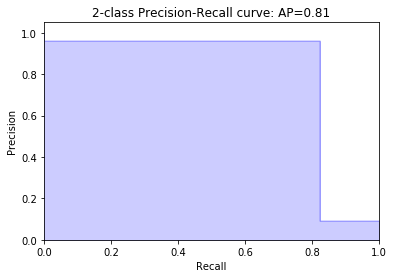

In [282]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Below code sample found at https://blog.taiker.space/ml-implement-decision-tree-in-python-with-cross-validation/

In [164]:
def report_top_parameters(grid_scores, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
            score.mean_validation_score,
            np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters